<a href="https://colab.research.google.com/github/MohamedMohana/Face-Mask-Detection-Recognition-Using-Colab/blob/main/Face_Mask_Detection_%26_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Google Drive with Colab


In [ ]:
# To read data directories and paths from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/"Your Files"/

In [ ]:
!pwd

In [ ]:
!ls

# Import Important Libraries

In [ ]:
#Install the face_recognition Lib 
!pip install face_recognition

In [ ]:
#To Preprocess the data (work only with ""GPU"")
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
#Convert images to vector (number) (work only with ""GPU"")
from tensorflow.keras.preprocessing.image import img_to_array
#To load the saved model
from tensorflow.keras.models import load_model
#Get the date 
from datetime import datetime
#Get the off-time
from time import sleep
#Import the library 
import face_recognition
#Import numpy for array
import numpy as np
#Import Time
import time
#Import OpenCV lib for Pictures 
import cv2
#Import files from the OS
import os
#Import Javacode
from IPython.display import display, Javascript
#Allow Java code to work in the Browser
from google.colab.output import eval_js
#To convert bytes that have binary or text data into ASCII characters
from base64 import b64decode, b64encode
#Image processing functions
import imutils
#To use cv2.imshow in google colab
from google.colab.patches import cv2_imshow
#To load the image
from PIL import Image
#To dealing with various types of I/O
import io 
#Access system-specific parameters and functions
import sys

#Train the Model


##Import libs

In [ ]:
# import the necessary DL packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

## Initialize the initial learning rate, number of epochs to train for,and batch size

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

## Load dataset & Categorize it 

In [ ]:
DIRECTORY = r"Mask_Data"

CATEGORIES = ["with_mask", "without_mask"]
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

[INFO] loading images...


## Create two list:
- Data & Labels
- Join each image to its right label based on the dataset
- Resize all images to 24 x 24
- Convert the Images to array --> _faster the process of the traning_
- Pre-process the input to suit the model --> in our case here MobileNetV2

In [ ]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)
    	data.append(image)
    	labels.append(category)

## Perform label binarizer encoding on the labels
* with mask [0  1] 
* without mask [1  0]

_This will help the output when caculating the probability using the activation function_ 



In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

## Chage data types to arrays

In [ ]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

##Split the data to train/test

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

## Construct the training image generator for data augmentation


In [ ]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

##MobileNetV2

- Since we are trasfer learning the model, so we acually do not need the top or last layer which beem trained to detect all the objects. so we will freez it and put our worn layers at the end to solve our problem and detect only the object we want.

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

9412608/9406464 [==============================] - 0s 0us/step


## Loop over all layers in the base model and freeze them so they will *not* be updated during the first training process

- This is because these layes been already trianed before, so why westing time doing again for months ^_^

In [ ]:
for layer in baseModel.layers:
	layer.trainable = False

## Compile our model
- We use the loss finction __binary crossentropy__ and __accuracy__ as a metrics

In [ ]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


##Start training 

- Only the head layers

In [ ]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
95/95 [==============================] - 52s 360ms/step - loss: 0.4196 - accuracy: 0.8316 - val_loss: 0.1705 - val_accuracy: 0.9752
Epoch 2/20
95/95 [==============================] - 33s 352ms/step - loss: 0.1520 - accuracy: 0.9641 - val_loss: 0.0978 - val_accuracy: 0.9765
Epoch 3/20
95/95 [==============================] - 33s 350ms/step - loss: 0.0961 - accuracy: 0.9792 - val_loss: 0.0750 - val_accuracy: 0.9778
Epoch 4/20
95/95 [==============================] - 33s 349ms/step - loss: 0.0777 - accuracy: 0.9782 - val_loss: 0.0644 - val_accuracy: 0.9817
Epoch 5/20
95/95 [==============================] - 33s 348ms/step - loss: 0.0628 - accuracy: 0.9822 - val_loss: 0.0563 - val_accuracy: 0.9831
Epoch 6/20
95/95 [==============================] - 33s 350ms/step - loss: 0.0563 - accuracy: 0.9855 - val_loss: 0.0489 - val_accuracy: 0.9857
Epoch 7/20
95/95 [==============================] - 33s 348ms/step - loss: 0.0486 - accuracy: 0.9878 - val_loss: 0.047

##Validation 
* Make predictions on the testing set

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


## Largest predicted probability
* So we can know it belongs to which label

In [ ]:
predIdxs = np.argmax(predIdxs, axis=1)

##Classification report for all:
- Accuracy 
- Precision
- Recall 
- F1-score 

In [ ]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.99       383
without_mask       0.99      0.98      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



## Save the model so we can use it again

In [ ]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

##Plot the results

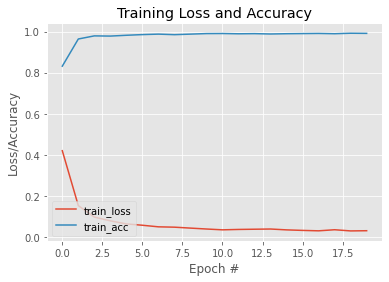

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
#plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
#print(H.history.keys())
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig("plot.png")
plt.show()

#To able the browser to open the camera in Colab

In [ ]:
def VideoCapture():
  js = Javascript('''
    async function create(){
      div = document.createElement('div');
      document.body.appendChild(div);

      video = document.createElement('video');
      video.setAttribute('playsinline', '');

      div.appendChild(video);

      stream = await navigator.mediaDevices.getUserMedia({video: {facingMode: "environment"}});
      video.srcObject = stream;

      await video.play();

      canvas =  document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      div_out = document.createElement('div');
      document.body.appendChild(div_out);
      img = document.createElement('img');
      div_out.appendChild(img);
    }


    async function capture(){
        return await new Promise(function(resolve, reject){
            pendingResolve = resolve;
            canvas.getContext('2d').drawImage(video, 0, 0);
            result = canvas.toDataURL('image/jpeg', 0.8);
            pendingResolve(result);
        })
    }

    function showimg(imgb64){
        img.src = "data:image/jpg;base64," + imgb64;
    }

  ''')
  display(js)

def byte2image(byte):
  jpeg = b64decode(byte.split(',')[1])
  im = Image.open(io.BytesIO(jpeg))
  return np.array(im)

def image2byte(image):
  image = Image.fromarray(image)
  buffer = io.BytesIO()
  image.save(buffer, 'jpeg')
  buffer.seek(0)
  x = b64encode(buffer.read()).decode('utf-8')
  return x

#Main Function

In [ ]:
class face_recog:
  def __init__(self):
    return None
  
  def loading(self):
    for i in range(3):
      os.system("cls")
      print("[*] Loading.")
      sleep(1)
      os.system("cls")
      print("[*] Loading..")
      sleep(1)
      os.system("cls")
      print("[*] Loading...")
      sleep(1)
  
    for cl in self.myList:
      curImg = cv2.imread("{}/{}".format(self.path,cl))
      self.images.append(curImg)
      self.classNames.append(os.path.splitext(cl)[0])

    print("[*] Pepole")
    sleep(1)
    print(self.classNames)
    sleep(1)
    print("[*] Encoding...")
    self.encodeListKnown = self.__findEncodings(self.images)
    print("[*] Encoding complete")
    sleep(1)
    print("[*] Opening Camera... ")

  def __findEncodings(self, images):
      encodeList = []
      for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        try:
          encode = face_recognition.face_encodings(img)[0]
        except IndexError as e:
          print(e)
        encodeList.append(encode)
      return encodeList

"""
Crete "Records.csv" file to report everyone and their status
"""
  def Records(self, name, label):
      with open('Records.csv','r+') as f:
        import timeit
        start = timeit.default_timer()
        myDataList = f.readlines()
        nameList = []
        label == label
        for line in myDataList:
          entry = line.split(',')
          nameList.append(entry[0])
        if name not in nameList:
          now = datetime.now()
          dtString = now.strftime('%H:%M:%S')
          f.writelines('\n{},{},{}'.format(name,label,dtString))
          stop = timeit.default_timer()
          print('Time: ', stop - start) 


class face_mask(face_recog):
  def __init__(self):
    """
    ------> Create a dataset of your own pictures and names <------
    Ex, Take one picture with mask and named it as "Mohd_1.jpg"
    and then take onother picture without mask and named it as "Mohd_2.jpg"
    after you are done, put all the images in a file "Your_Own_Images"
    """
    self.path='/Your_Own_Images File Directory' 
    self.images = []
    self.classNames = []
    self.myList = os.listdir(self.path)
    self.font = cv2.FONT_HERSHEY_SIMPLEX
    face_recog.loading(self)
    self.prototxtPath = r"/face_detector/deploy.prototxt"
    self.weightsPath = r"/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
    return None

  def __detect_mask(self, frame, faceNet, maskNet):
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
      (104.0, 177.0, 123.0))
    faceNet.setInput(blob)
    detections = faceNet.forward()
    faces = []
    locs = []
    preds = []

    for i in range(0, detections.shape[2]):
      confidence = detections[0, 0, i, 2]
      if confidence > 0.5:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
        face = frame[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        faces.append(face)
        locs.append((startX, startY, endX, endY))

    if len(faces) > 0:
      faces = np.array(faces, dtype="float32")
      preds = maskNet.predict(faces, batch_size=32)
    return (locs, preds)

  def main_proj(self):
    faceNet = cv2.dnn.readNet(self.prototxtPath, self.weightsPath)
    maskNet = load_model("/mask_detector.model")
    print("[INFO] starting video stream...")
    VideoCapture()
    eval_js('create()')

    while True:
      byte = eval_js('capture()')
      frame = byte2image(byte)
      imgS = cv2.resize(frame, (0,0), None, 0.25,0.25)
      imgS = cv2.cvtColor(imgS, cv2.COLOR_BGR2RGB)
      facesCurFrame = face_recognition.face_locations(imgS)
      encodesCurFrame = face_recognition.face_encodings(imgS, facesCurFrame)
      (locs, preds) = self.__detect_mask(frame, faceNet, maskNet)

      for (box, pred) in zip(locs, preds):
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred
        label = "Mask" 
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        if mask > withoutMask:
          label = "Mask"
        else:
          lable = "No Mask"
        
        if label == "Mask": 
          label = "With Mask"
          #print("yes with mask")
          # font = cv2.FONT_HERSHEY_DUPLEX
          # cv2.putText(frame, "WITH MASK", (startX, startY - 10),
          # font, 0.45, (255, 255, 255), 1)
          # cv2.rectangle(frame, (startX, startY), (endX, endY), (255, 255, 255), 1)

          for encodeFace, faceLoc in zip(encodesCurFrame, facesCurFrame):
            matches = face_recognition.compare_faces(self.encodeListKnown, encodeFace)
            faceDis = face_recognition.face_distance(self.encodeListKnown, encodeFace)
            #print(faceDis)
            matchIndex = np.argmin(faceDis)
            if matches[matchIndex]:
              name = self.classNames[matchIndex].upper()
              #print(name)
              #name = name + '\n'  + lable
              y1, x2, y2, x1 = faceLoc
              y1, x2, y2, x1 = y1*4,x2*4,y2*4,x1*4
              self.Records(name, label)
              #self.markAttendance(label)
              cv2.rectangle(frame, (startX, startY), (endX, endY), (255, 255, 255), 1)
              font = cv2.FONT_HERSHEY_DUPLEX
              # cv2.putText(frame, name + " -->  WITHOUT MASK", (startX, startY - 10),
              # font, 0.45, (0,0,0), 1)
              text = name + '\nWITH MASK'
              y0, dy = 50, 25
 
              for i, txt in enumerate(text.split('\n')):
                  y = y0+i*dy
                  cv2.putText(frame, txt, (startX, y + 25), font,  0.60 , (255, 255, 255), 1)
        else:
          label = "Without Mask"
          for encodeFace, faceLoc in zip(encodesCurFrame,facesCurFrame):
            matches = face_recognition.compare_faces(self.encodeListKnown, encodeFace)
            faceDis = face_recognition.face_distance(self.encodeListKnown, encodeFace)
            #print(faceDis)
            matchIndex = np.argmin(faceDis)
            if matches[matchIndex]:
              name = self.classNames[matchIndex].upper()
              #print(name)
              #name = name + '\n'  + lable
              y1, x2, y2, x1 = faceLoc
              y1, x2, y2, x1 = y1*4, x2*4, y2*4, x1*4
              self.Records(name,label)
              #self.markAttendance(label)
              cv2.rectangle(frame, (startX, startY), (endX, endY), (0,0,0), 1)
              font = cv2.FONT_HERSHEY_DUPLEX
              # cv2.putText(frame, name + " -->  WITHOUT MASK", (startX, startY - 10),
              # font, 0.45, (0,0,0), 1)
              text = name + '\nWITHOUT MASK'
              y0, dy = 50, 25
 
              for i, txt in enumerate(text.split('\n')):
                  y = y0+i*dy
                  cv2.putText(frame, txt, (startX, y + 25), font,  0.60 , (0, 0, 0), 1)

              #cv2.putText(frame, name + "     WITHOU٢T MASK", (startX, startY - 10),
              #cv2.rectangle(frame,(x1,y1),(x2,y2),(0,0,255),2)
              #cv2.rectangle(frame,(x1,y2-35),(x2,y2),(0,0,255),cv2.FILLED)
              #cv2.putText(frame,name,(x1+6,y2-6),self.font,1,(255,255,255),2)

              #print("Person on Black List")

            # else:
            #   cv2.putText(frame, "without mask", (startX, startY - 10),
            #   self.font, 0.45, (0,0,255), 2)
            #   cv2.rectangle(frame, (startX, startY), (endX, endY), (0,0,255), 2)
            #   #print("without mask")

      print(label)
      eval_js('showimg("{}")'.format(image2byte(frame)))



if __name__ == "__main__":
  obj = face_mask()
  face_mask.main_proj.__call__(obj)